# The redshift evolution of the BBH merger rate: "a weighty matter"

## Figure 6: the contribution of different metallicities to the BH primary mass distribution 


## Imports and definitions:

In [1]:
######################################
## Imports
import numpy as np
import h5py as h5

from astropy.table import Table, Column
import astropy.units as u
from astropy import constants as const

import matplotlib.pyplot as plt
import seaborn as sns
import astropy.units as u

from matplotlib import ticker, cm

from scipy import stats

# Chosen cosmology 
from astropy.cosmology import WMAP9 as cosmo
from astropy.cosmology import z_at_value

# Extra python functions
import HelperFunctions as func

######################################
## locations
save_loc    =  '../plots/'
data_dir    = '../output/'

# This will be put in front of the name for every figure we safe 
sim_save_str = 'N1e7_'

######################################
## PLOT setttings
plt.rc('font', family='serif')
from matplotlib import rc
import matplotlib
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'STIXGeneral'
rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
rc('text', usetex=True)
fsize, SMALL_SIZE, MEDIUM_SIZE, BIGGER_SIZE = 30,25,25,30
for obj in ['axes','xtick','ytick']:
    plt.rc(obj, labelsize=MEDIUM_SIZE)          # controls default text sizes
for obj in ['figure','axes']:
    plt.rc(obj, titlesize=BIGGER_SIZE)    # fontsize of the tick labels
plt.rc('font', size=MEDIUM_SIZE)          # controls default text sizes
plt.rc('legend', fontsize=SMALL_SIZE)    # legend fontsize


######################################
## Widescreen jupyter notebook
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Read your data

the function `read_data` is part of `HelperFunctions.py` and reads the hdf5 file containing the BBH population data and merger rates. This is expensive memory-wise
Hence the columns specifically needed for this  Figure are loaded right below that

The Bool "DCO_mask" filters for BBHs:  
1. with an inspiral time that is less than the age of the Universe
2. excludes systems that experienced a CE from a HG donor (i.e. the flag `Optimistic_CE == False`)
3. excludes systems that experienced RLOF immediately following a CE (i.e. the flag `Immediate_RLOF>CE == False`)

In other words, we treat 2. and 3. as stellar mergers and exclude them from the rest of our analysis

Lastly, we select merging BBHs using the `DCO_mask`, and aditionally exclude systems that evolve Chemically homogeneous. 


In [7]:
####################################################
## Location of your data
File_location = data_dir+'COMPAS_Output_wWeights.h5'
print(File_location)

# Rate selects wich mergers you are interested in, using a specific SFRD
rate_key      = 'Rates_mu00.025_muz-0.05_alpha-1.77_sigma01.125_sigmaz0.05_zBinned'

####################################################
'''
The following function will read more information (generally useful for all plots in paper)
Warning, this is heavy on memory usage 
Bare essential data will be read below
DCO, DCO_mask, redshifts, Average_SF_mass_needed, intrinsic_rate_density, intrinsic_rate_density_z0, = func.read_data(loc = File_location, rate_key = rate_key)
DCO.info()
'''

################################################
## Essential data for this plot
## Open hdf5 file and read relevant columns
File        = h5.File(File_location ,'r')

DCO = Table()
DCO['SEED']                  = File['DoubleCompactObjects']['SEED'][()] 
DCO['Metallicity@ZAMS(1)']   = File['DoubleCompactObjects']['Metallicity@ZAMS(1)'][()] 
DCO['CE_Event_Count']        = File['DoubleCompactObjects']['CE_Event_Count'][()] 
DCO['M_moreMassive']         = np.maximum(File['DoubleCompactObjects']['Mass(1)'][()], File['DoubleCompactObjects']['Mass(2)'][()])

SYS_DCO_seeds_bool           = np.in1d(File['SystemParameters']['SEED'][()], DCO['SEED']) #Bool to point SYS to DCO
DCO['Stellar_Type@ZAMS(1)']  = File['SystemParameters']['Stellar_Type@ZAMS(1)'][SYS_DCO_seeds_bool]

DCO_mask                     = File[rate_key]['DCOmask'][()] # Mask from DCO to merging BBH 
intrinsic_rate_density       = File[rate_key]['merger_rate'][()]
redshifts                    = File[rate_key]['redshifts'][()]

File.close()

################################################
# Bools to select merging BBHs w.o. CHE only
nonCHE_bool         = DCO['Stellar_Type@ZAMS(1)'] != 16
rate_nonCHE_bool    = DCO['Stellar_Type@ZAMS(1)'][DCO_mask] != 16

# Filter both the BBH table and the intrinsic rate data
merging_BBH         = DCO[DCO_mask * nonCHE_bool]
Red_intr_rate_dens  = intrinsic_rate_density[rate_nonCHE_bool, :]


../output/COMPAS_Output_wWeights.h5


# Look at contribution from different metallicities to the BH mass distribution

In [5]:
# Distribution plot function
def plot_dist_by_redshift_Z(table, x_key, WEIGHTS, log = False, kde_width = 0.1, 
                            redshift_list = redshifts, fill=True,
                            metal_edges = [-3.5,-3,-2.5,-2,-1.5], annotate_stuff=True,
                            bins = np.arange(0,50,2),  z_bin_edges = [1,2,3,4],
                            savestr = '', save_plot=False, x_lim=(0,52.5), y_lim = (0,1000), 
                            colors = ['#488496', '#73bdb3', '#e388b0'],
                            xlabel = '$M_{\mathrm{BH,1} \ } [\mathrm{M_{\odot}} ]$',
                            ylabel = r'$R_{\mathrm{BBH} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}}]}$',):
    
    # centers of redshif bins
    center_z = (redshift_list[:-1] + redshift_list[1:])/2.
    #########################################
    # centers of redshif bins
    center_z = (redshift_list[:-1] + redshift_list[1:])/2.
    #Centers of your crude redshift bins
    center_Crude_bins = (z_bin_edges[:-1] + z_bin_edges[1:])/2. # center points

    ##############################
    ## Calculate average rate density per z-bin
    crude_rate_density = func.get_crude_rate_density(WEIGHTS, redshift_list, z_bin_edges)
    
    #########################################
    # labels based on z_bin_edges
    labels     = ['$%s \leq \mathrm{merger \ redshift,} z < %s$'%(z_bin_edges[a],z_bin_edges[a+1]) for a in range(0,len(z_bin_edges)-1) ]
    
    #########################################
    # METAL bools
    table['logZ'] = np.log10(table['Metallicity@ZAMS(1)'])
    metal_bool_list = [np.logical_and(table['logZ'] > metal_edges[a], table['logZ']<= metal_edges[a+1]) for a in range(0,len(metal_edges)-1) ]
    metal_bool_list.insert(0,table['logZ'] < metal_edges[0])
    metal_bool_list.insert(len(metal_bool_list),table['logZ'] > metal_edges[-1])
    # add one bool for to include the total 
    metal_bool_list.insert(len(metal_bool_list),table['logZ'] < metal_edges[-1])
    print(len(metal_bool_list))
    
    metal_labels     = ['$%s < \log_{10}Z \leq %s$'%(metal_edges[a],metal_edges[a+1]) for a in range(0,len(metal_edges)-1) ]
    metal_labels.insert(0,'$%s < \log_{10}Z \leq %s$'%(-4, metal_edges[0]))
#     metal_labels.insert(0,'$\log_{10}(Z) \leq %s$'%(metal_edges[0]))
    metal_labels.insert(len(metal_bool_list),'$%s < \log_{10}Z \leq %s$'%(metal_edges[-1],-1.5))
#     metal_labels.insert(len(metal_bool_list),'$\log_{10}Z \geq %s$'%(metal_edges[-1]))
    # add one bool for to include the total 
    metal_labels.insert(len(metal_bool_list),'$\mathrm{All} \ Z$')

    
    #########################################
    # Start plotting
    fig, ax = plt.subplots(figsize = (14, 8))

    zorders = [1,2,3,4,0] 

    for i in range(len(center_Crude_bins)):
        for met, metal_bool in enumerate(metal_bool_list):
            print('!!!', metal_labels[met], '\n')
            ########################
            # X value and weight
            x_vals = table[x_key][metal_bool]
            m_Weight     = crude_rate_density[metal_bool,i]
        

            ########################
            # Get the Hist    
            hist, bin_edge = np.histogram(x_vals, weights = m_Weight, bins=bins)
            center_bins = (bin_edge[:-1] + bin_edge[1:])/2.
            # And the KDE
#             kde_width = stats.gaussian_kde.silverman_factor(x_vals, weights=m_Weight)
            kernel = stats.gaussian_kde(x_vals, bw_method= kde_width, weights=m_Weight)
            binwidth = np.diff(bin_edge)


            ########################
            # Add KDE
            x_KDE = np.arange(2.5,bins[-1],0.1)
            KDEy_vals = kernel(x_KDE)*sum(hist)*np.diff(bins)[0] #re-normalize the KDE
            
            # Find the max BH mass and metal bin
            Mbh_max = max(x_KDE[KDEy_vals > 1e-3])
            
            if met == len(metal_bool_list)-1:
                ax.text(np.round(Mbh_max,1), 8, s='$M_{\mathrm{BH,max}}$'+r'$ \ \approx \ $'+'$ %s \mathrm{M_{\odot}}$'%(int(np.round(Mbh_max)) )+'\n'+metal_labels[met],
                        rotation=0, color = colors[met], size = 30, va = 'bottom', ha = 'right', zorder = 20,
                        bbox=dict(facecolor='white', edgecolor='none', boxstyle='round,pad=0.5', alpha = 0.9))
                labelstr = None
            else:
                labelstr = metal_labels[met]+'\n'+'$M_{\mathrm{BH,max}}$'+r'$ \ \approx \ $'+'$ %s \mathrm{M_{\odot}}$'%(int(np.round(Mbh_max)) )
            
            ax.plot(x_KDE, KDEy_vals, lw=5, color=colors[met], zorder = zorders[met],label = labelstr)#metal_labels[met])
            if met == len(metal_bool_list)-1:
                fill=False #don't fill the overall dist
            if fill:
                ax.fill_between(x_KDE, y1=0, y2=KDEy_vals, color=sns.color_palette("rainbow", 10)[1], alpha = 0.05, zorder = i+1)
                

    #########################################
    # plot values
    ax.set_xlim(x_lim)
    ax.set_ylim(y_lim)
    leg = ax.legend(fontsize = 22,bbox_to_anchor=(1.005, 0.85), loc='upper left')

    plt.title(labels[i])
    
    ax.set_xlabel(xlabel, fontsize = 35)
    ax.set_ylabel(ylabel, fontsize = 30)
    ax.tick_params(axis='both', labelsize= 35)
    if log:
        ax.set_yscale('log')
        
    if save_plot:
        plt.savefig(save_loc+'/Mass_dist_by_metallicity'+savestr+'.pdf', bbox_inches='tight')
        plt.savefig(save_loc+'/png_versions/Mass_dist_by_metallicity'+savestr+'.png', bbox_inches='tight')

    plt.show()


    

i_per_crude_bin 40.0
5
!!! $-4 < \log_{10}Z \leq -3$ 

!!! $-3 < \log_{10}Z \leq -2.5$ 

!!! $-2.5 < \log_{10}Z \leq -2$ 

!!! $-2 < \log_{10}Z \leq -1.5$ 

!!! $\mathrm{All} \ Z$ 



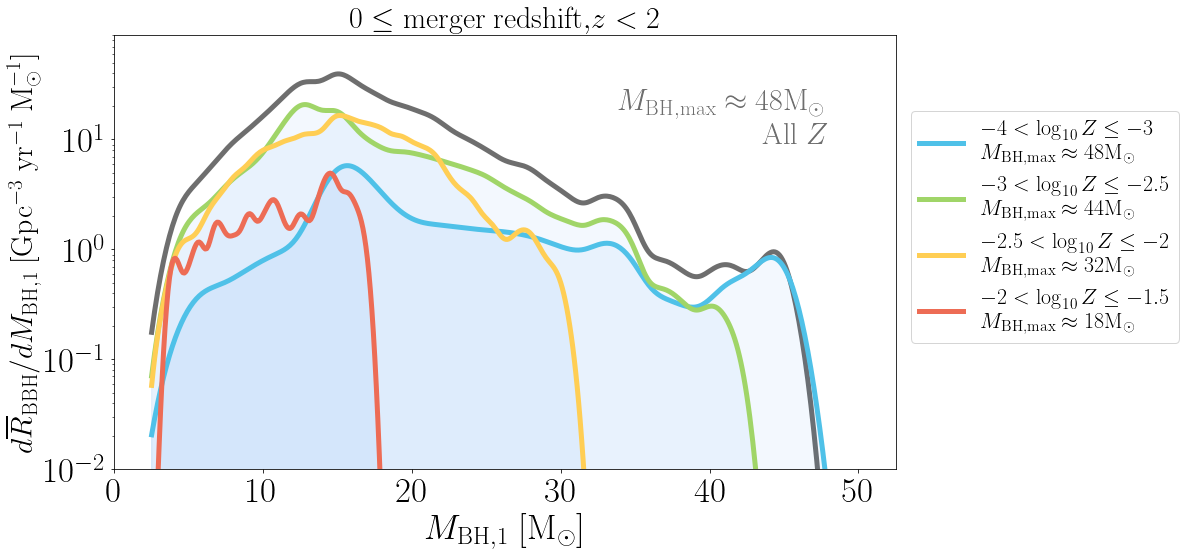

In [8]:
kleuren          = sns.color_palette("rainbow", 10)
kleuren_lijst    = kleuren[:]
kleuren_lijst = [kleuren[e] for e in [1,3,7,8]] 
kleuren_lijst.insert(len(kleuren_lijst),(0.6, 0.6, 0.6))

kleuren_lijst = ['#4FC1E8', '#A0D568', '#FFCE54', '#ed6c55', '#6e6e6e']

#Full z range
plot_dist_by_redshift_Z(merging_BBH, 'M_moreMassive', Red_intr_rate_dens, 
                        metal_edges = [-3,-2.5,-2],fill=True,
                        colors = kleuren_lijst, y_lim = (1e-2,9e1), z_bin_edges = np.array([0,2]),
                        ylabel = r'$d\overline{R}_{\mathrm{BBH}}/dM_{\mathrm{BH,1}} \ \mathrm{[Gpc^{-3} \ yr^{-1} \ M_{\odot}^{-1}]}$',
                        log = True, savestr = sim_save_str+'0z_leq2', save_plot=True)


